In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import math
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

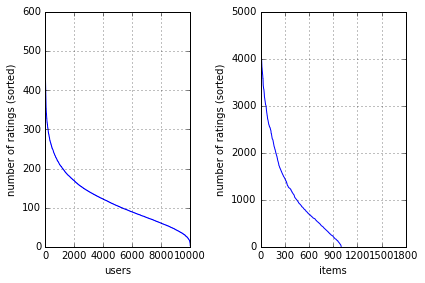

min # of items per user = 3, min # of users per item = 8.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [5]:
from plots import plot_train_test_data
from helpers import split_data

valid_ratings, train_unfiltered, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)


Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1058987
Total number of nonzero elements in test data:117965


In [6]:
from outliers_filtering import *
#d = disagreements(train_unfiltered)
#plot_disagreements(d)
#train = filter_outliers(train_unfiltered,d)
#nfiltered = train_unfiltered.nnz - train.nnz
#print("number of filtered ratings : {}".format(nfiltered))
train = train_unfiltered

In [7]:
from outliers_filtering import threshold_tests
threshold_tests(d, train_unfiltered, valid_ratings, test)

NameError: name 'd' is not defined

## Implementing Baselines 

### Use the global mean to do the prediction

In [ ]:
from helpers import calculate_mse
from baselines import baseline_global_mean, compute_rmse

train_mean, test_mean = baseline_global_mean(train, test)
pred = np.ones(train.shape) * train_mean
test_pred = np.ones(test.shape) * test_mean


rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Use the user means as the prediction

In [ ]:
from baselines import baseline_user_mean

train_means, test_means = baseline_user_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[1]):
    pred[:,col] *= train_means_list[0][col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[1]):
    test_pred[:,col] *= test_means_list[0][col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Use the item means as the prediction

In [ ]:
from baselines import baseline_item_mean
from helpers import exportSubmission

train_means, test_means = baseline_item_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[0]):
    pred[col,:] *= train_means_list[col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[0]):
    test_pred[col,:] *= test_means_list[col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

Compute the cost by the method of matrix factorization.


iter: k = 30, RMSE on training set: 1.2826366743059094.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1652413854957016.
iter: 1, RMSE on training set: 1.1360706329384835.
iter: 2, RMSE on training set: 1.120765317861365.
iter: 3, RMSE on training set: 1.1097899475162887.
iter: 4, RMSE on training set: 1.10100518051741.
iter: 5, RMSE on training set: 1.093787076725583.
iter: 6, RMSE on training set: 1.0876387676254093.
iter: 7, RMSE on training set: 1.0823513357181214.
iter: 8, RMSE on training set: 1.077481927383368.
iter: 9, RMSE on training set: 1.0733357525613567.
iter: 10, RMSE on training set: 1.0694165877531585.
iter: 11, RMSE on training set: 1.0658033606717043.
iter: 12, RMSE on training set: 1.0626437325188705.
iter: 13, RMSE on training set: 1.05967692138783.
iter: 14, RMSE on training set: 1.0569594281706827.
iter: 15, RMSE on training set: 1.054440987635389.
iter: 16, RMSE on training set: 1.0521243400726428.
iter: 17, RMSE on training set: 1.

KeyboardInterrupt: 

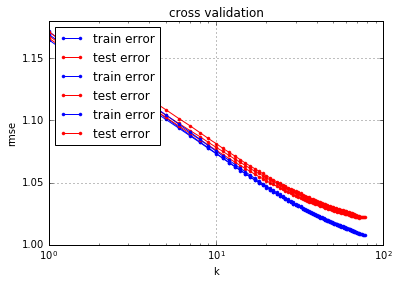

In [13]:
from matrix_factorization import multiple_matrix_factorization_SGD
from helpers import pick_lowest_rmse
# set seed
np.random.seed(988)
results = multiple_matrix_factorization_SGD(train, test, num_epochs=500, ntries=5)
print(results)
rmse, user_features, item_features = pick_lowest_rmse(test, results, test.nonzero())
print(rmse)

In [59]:
from helpers import exportSubmission
pred =  (item_features @ user_features.T)
exportSubmission("data/submission_MF.csv", pred)

number of items: 1000, number of users: 10000


iter: k = 1, RMSE on training set: 3.5399128566885905.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 2.5306706076187337.
iter: 1, RMSE on training set: 2.2520266120110475.
iter: 2, RMSE on training set: 2.1406059268525914.
iter: 3, RMSE on training set: 2.068950725560857.
iter: 4, RMSE on training set: 2.0153373701958963.
iter: 5, RMSE on training set: 1.9701914379581311.
iter: 6, RMSE on training set: 1.930720689968107.
iter: 7, RMSE on training set: 1.895462546505284.
iter: 8, RMSE on training set: 1.86275103543634.
iter: 9, RMSE on training set: 1.8326180523663127.
iter: 10, RMSE on training set: 1.8042787575669539.
iter: 11, RMSE on training set: 1.7779824182477528.
iter: 12, RMSE on training set: 1.7531689463231526.
iter: 13, RMSE on training set: 1.7295484823492693.
iter: 14, RMSE on training set: 1.707257313792222.
iter: 15, RMSE on training set: 1.685954843147697.
iter: 16, RMSE on training set: 1.665990520399188.
iter: 17, RMSE on training set: 1.6

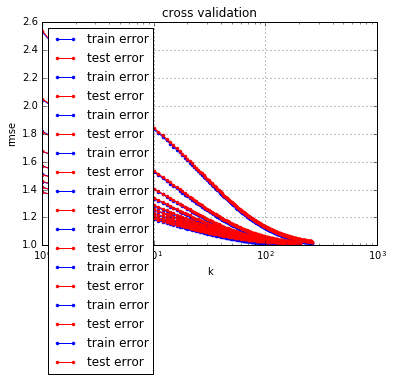

In [17]:
from matrix_factorization import matrix_factorization_SGD
from helpers import compute_error
user_features_list = []
item_features_list = []
errors = []
for i in np.arange(1, 10, 1):
    user_features, item_features = matrix_factorization_SGD(train, test, num_epochs = 1000, num_features = i)
    user_features_list.append(user_features)
    item_features_list.append(item_features)
    error = compute_error(test, user_features, item_features, test.nonzero())
    errors.append(error)


[1.0186759666252296, 1.0244263026265359, 1.0257569212870854, 1.022561844657071, 1.0220729199621359, 1.0218532842253376, 1.0228101086971249]


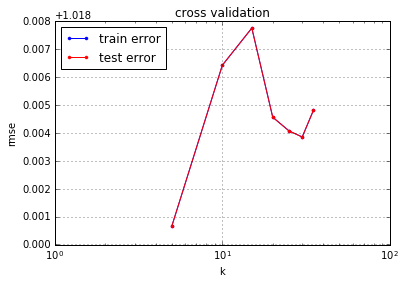

In [15]:
from plots import visualization
visualization(np.arange(5, 40, 5),errors,errors)
print(errors)

[1.0275355618021744, 1.0193485416482588, 1.0165711399987947, 1.021803538491332, 1.0186201573322433, 1.018274370071462, 1.0251607910111309, 1.0259719083497403, 1.0272712595581064]


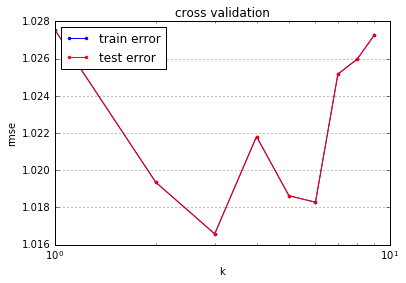

In [18]:
from plots import visualization
visualization(np.arange(1, 10, 1),errors,errors)
print(errors)

In [24]:
user_features = user_features_list[2]
item_features = item_features_list[2]
compute_error(test, user_features, item_features, test.nonzero())

1.0165711399987947

In [33]:
np.save("data/features/best2_user_features.npy", user_features)
np.save("data/features/best2_item_features.npy", item_features)

iter: k = 3, RMSE on training set: 2.2753209349077133.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.8089586819871928.
iter: 1, RMSE on training set: 1.6700937118737316.
iter: 2, RMSE on training set: 1.6001962018722375.
iter: 3, RMSE on training set: 1.549741219905791.
iter: 4, RMSE on training set: 1.50947127484687.
iter: 5, RMSE on training set: 1.4754002540476134.
iter: 6, RMSE on training set: 1.4454424063178315.
iter: 7, RMSE on training set: 1.4190865880068335.
iter: 8, RMSE on training set: 1.3952779162133404.
iter: 9, RMSE on training set: 1.3736885945790736.
iter: 10, RMSE on training set: 1.3541209968464814.
iter: 11, RMSE on training set: 1.3359993767094382.
iter: 12, RMSE on training set: 1.319519064165857.
iter: 13, RMSE on training set: 1.3042211655162954.
iter: 14, RMSE on training set: 1.2901371643112136.
iter: 15, RMSE on training set: 1.277051098433284.
iter: 16, RMSE on training set: 1.2647361970817095.
iter: 17, RMSE on training set: 

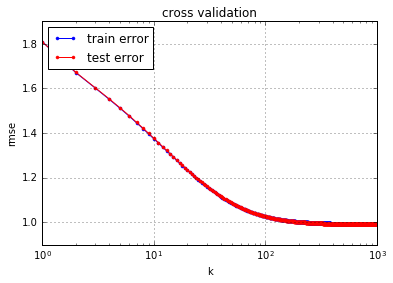

In [32]:
user_features, item_features = matrix_factorization_SGD(valid_ratings, test, num_epochs = 1000, num_features = 3)

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)

In [ ]:
###Computing prediction

In [ ]:
pred = np.ones(valid_ratings.shape)
for col in range(valid_ratings.shape[0]):
    pred[col,:] *= ratings_means_list[col]
    
exportSubmission("data/final_submission.csv", pred)